In [1]:
import pandas as pd

csv_path = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\init_data\pKa_Prediction_Starting data_2024.05.07.csv'

df = pd.read_csv(csv_path, index_col=0)

pKa

In [160]:
df_pKa = df.dropna(subset = ['pKa'])

In [161]:
import random

q_amount = 9
test_elements_per_bin = 4
df_pKa['bin'] = pd.qcut(df_pKa['pKa'], q=q_amount, labels=False)

all_indexes = df_pKa.index.tolist()
test_indexes = []

for bin_index in range(q_amount):
    df_temp = df_pKa[df_pKa['bin'] == bin_index]
    bin_indexes = df_temp['pKa'].index.tolist()
    
    test_indexes_in_bin = random.sample(bin_indexes, test_elements_per_bin)
    # test_indexes_in_bin = random.choices(bin_indexes, k=test_elements_per_bin)
    test_indexes += test_indexes_in_bin

train_indexes = []
for element in all_indexes:
    if element not in test_indexes:
        train_indexes.append(element)

C:\Users\38066\AppData\Local\Temp\ipykernel_6252\3270024339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pKa['bin'] = pd.qcut(df_pKa['pKa'], q=q_amount, labels=False)


In [162]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

def compare_smi(smi1, smi2):
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)

    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)

    similarity = DataStructs.TanimotoSimilarity(fp1, fp2)

    return similarity

molecules_to_train = 0
for test_index in test_indexes:
    test_smi = df_pKa.loc[test_index]['Smiles']
    max_similarity = 0
    similar_smi = ''
    for train_index in train_indexes:
        train_smi = df_pKa.loc[train_index]['Smiles']
        similarity = compare_smi(test_smi, train_smi)
        if similarity > max_similarity:
            max_similarity = similarity
            similar_smi = train_smi
    
    if max_similarity > 0.9:
        train_indexes.append(test_index)
        test_indexes.remove(test_index)
        molecules_to_train += 1
    
    print(f"similarity: {max_similarity}, test index: {test_index}, test smi: {test_smi}, train smi: {similar_smi}, bin: {df_pKa.loc[test_index]['bin']}")

print(molecules_to_train)

similarity: 0.5161290322580645, test index: 36, test smi: O=C(O)C12CC(C(F)(F)F)(CO1)C2, train smi: O=C(O)C12CC(C(F)F)(CO1)C2, bin: 0
similarity: 1.0, test index: 10, test smi: O=C(O)[C@H]1C[C@H](C(F)(F)F)C1, train smi: O=C(O)[C@H]1C[C@@H](C(F)(F)F)C1, bin: 0
similarity: 0.34375, test index: 38, test smi: O=C(O)C12CC(CO1)C2, train smi: O=C(O)C12CC(C(F)F)(CO1)C2, bin: 0
similarity: 1.0, test index: 15, test smi: O=C(O)[C@H]1C[C@@H](CF)C1, train smi: O=C(O)[C@H]1C[C@H](CF)C1, bin: 1
similarity: 1.0, test index: 43, test smi: O=C(O)[C@@H]1C[C@H]1C(F)(F)F, train smi: O=C(O)[C@H]1C[C@H]1C(F)(F)F, bin: 1
similarity: 0.5769230769230769, test index: 34, test smi: O=C(O)C1CC2(CC(F)C2)C1, train smi: O=C(O)C1CC2(C1)CC(F)(F)C2, bin: 2
similarity: 0.5, test index: 51, test smi: O=C(O)C1CC12CC2, train smi: O=C(O)C1CC1(F)F, bin: 2
similarity: 0.5, test index: 82, test smi: O=S1(=O)CC2CNCC(C1)C2(F)F, train smi: FC1(F)CC2CNCC(C1)C2(F)F, bin: 2
similarity: 0.43478260869565216, test index: 28, test smi: O

In [163]:
train_pKa = df_pKa.loc[train_indexes]['pKa']
test_pKa = df_pKa.loc[test_indexes]['pKa']

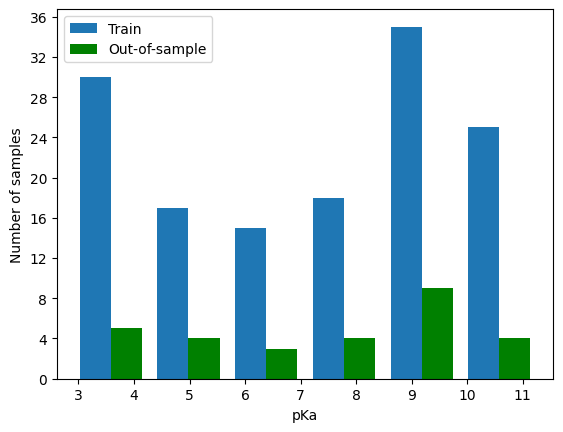

In [172]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

labels = ["Train", "Out-of-sample"]
colors = ["#1f77b4", "green"]

ax = plt.figure().gca() # gca stands for 'get current axis'
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.hist((train_pKa, test_pKa), bins=6, color=colors, label=labels)

plt.legend()
plt.xlabel("pKa")
plt.ylabel("Number of samples")

plt.show()

In [180]:
train_df = df_pKa.loc[train_indexes]
test_df = df_pKa.loc[test_indexes]

In [183]:
df_pKa

,Reference,Smiles,LogP,pKa,Structure,MW,Amine or acid,Bemis-Murcko,Framework,F group,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Atoms in ring,Amides for LogP,Unnamed: 19,F atom fraction,identificator,bin
0,10.1016/j.jfluchem.2023.110215,O=C(O)C1CCC(F)(F)CC1,2.63,4.32,NaN,164.152,Acid,NaN,cyclohexane,gem-CF2,...,0,2,0,0,6.0,O=C(Nc1ccccc1)C1CCC(F)(F)CC1,NaN,0.285714,Carboxylic acid,1
1,10.1016/j.jfluchem.2023.110215,O=C(O)C1CCCCC1,2.88,4.85,NaN,128.171,Acid,NaN,cyclohexane,non-F,...,0,0,0,0,6.0,O=C(Nc1ccccc1)C1CCCCC1,NaN,0.000000,Carboxylic acid,2
2,10.1016/j.jfluchem.2023.110215,O=C(O)[C@H]1C[C@@H]2C[C@@H]2C1,2.87,4.35,NaN,126.155,Acid,NaN,bicyclo[3.1.0]hexane,non-F,...,0,0,0,0,6.0,O=C(Nc1ccccc1)[C@H]1C[C@@H]2C[C@@H]2C1,NaN,0.000000,Carboxylic acid,1
3,10.1016/j.jfluchem.2023.110215,O=C(O)[C@@H]1C[C@@H]2C[C@@H]2C1,2.92,4.24,NaN,126.155,Acid,NaN,bicyclo[3.1.0]hexane,non-F,...,0,0,0,0,6.0,O=C(Nc1ccccc1)[C@@H]1C[C@@H]2C[C@@H]2C1,NaN,0.000000,Carboxylic acid,1
4,10.1016/j.jfluchem.2023.110215,O=C(O)[C@H]1C[C@@H]2[C@H](C1)C2(F)F,2.37,3.80,NaN,162.136,Acid,NaN,bicyclo[3.1.0]hexane,gem-CF2,...,0,2,0,0,6.0,O=C(Nc1ccccc1)[C@H]1C[C@@H]2[C@H](C1)C2(F)F,NaN,0.285714,Carboxylic acid,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,10.1021/acs.joc.0c01848,N[C@H]1C[C@H]1C(F)F,1.36,7.16,NaN,107.104,Amine,NaN,cyclopropane,CHF2,...,1,1,0,0,3.0,O=C(N[C@H]1C[C@H]1C(F)F)c1ccccc1,NaN,0.500000,Primary amine,4
167,10.1021/acs.joc.0c01848,C[C@@H]1C[C@H]1N,1.83,9.44,NaN,71.123,Amine,NaN,cyclopropane,non-F,...,0,0,0,0,3.0,C[C@@H]1C[C@H]1NC(=O)c1ccccc1,NaN,0.000000,Primary amine,6
168,10.1021/acs.joc.0c01848,C[C@@H]1C[C@@H]1N,1.64,9.15,NaN,71.123,Amine,NaN,cyclopropane,non-F,...,0,0,0,0,3.0,C[C@@H]1C[C@@H]1NC(=O)c1ccccc1,NaN,0.000000,Primary amine,6
171,10.1002/ejoc.202200863,NC1CC12CC2,2.08,9.41,NaN,83.134,Amine,NaN,spiro[2.2]pentane,non-F,...,0,0,0,0,5.0,O=C(NC1CC12CC2)c1ccccc1,NaN,0.000000,Primary amine,6


In [182]:
train_df.to_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\train_test\canon_smiles_train_test\train_pKa.csv')
test_df.to_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\train_test\canon_smiles_train_test\test_pKa.csv')

In [177]:
train_df 

,Reference,Smiles,LogP,pKa,Structure,MW,Amine or acid,Bemis-Murcko,Framework,F group,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Atoms in ring,Amides for LogP,Unnamed: 19,F atom fraction,identificator,bin
0,10.1016/j.jfluchem.2023.110215,O=C(O)C1CCC(F)(F)CC1,2.63,4.32,NaN,164.152,Acid,NaN,cyclohexane,gem-CF2,...,0,2,0,0,6.0,O=C(Nc1ccccc1)C1CCC(F)(F)CC1,NaN,0.285714,Carboxylic acid,1
1,10.1016/j.jfluchem.2023.110215,O=C(O)C1CCCCC1,2.88,4.85,NaN,128.171,Acid,NaN,cyclohexane,non-F,...,0,0,0,0,6.0,O=C(Nc1ccccc1)C1CCCCC1,NaN,0.000000,Carboxylic acid,2
2,10.1016/j.jfluchem.2023.110215,O=C(O)[C@H]1C[C@@H]2C[C@@H]2C1,2.87,4.35,NaN,126.155,Acid,NaN,bicyclo[3.1.0]hexane,non-F,...,0,0,0,0,6.0,O=C(Nc1ccccc1)[C@H]1C[C@@H]2C[C@@H]2C1,NaN,0.000000,Carboxylic acid,1
4,10.1016/j.jfluchem.2023.110215,O=C(O)[C@H]1C[C@@H]2[C@H](C1)C2(F)F,2.37,3.80,NaN,162.136,Acid,NaN,bicyclo[3.1.0]hexane,gem-CF2,...,0,2,0,0,6.0,O=C(Nc1ccccc1)[C@H]1C[C@@H]2[C@H](C1)C2(F)F,NaN,0.285714,Carboxylic acid,0
5,10.1016/j.jfluchem.2023.110215,O=C(O)[C@@H]1C[C@@H]2[C@H](C1)C2(F)F,2.88,3.76,NaN,162.136,Acid,NaN,bicyclo[3.1.0]hexane,gem-CF2,...,0,2,0,0,6.0,O=C(Nc1ccccc1)[C@@H]1C[C@@H]2[C@H](C1)C2(F)F,NaN,0.285714,Carboxylic acid,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,10.1021/acs.joc.0c01848,O=C(O)[C@@H]1C[C@H]1C(F)(F)F,2.98,3.88,NaN,154.088,Acid,NaN,cyclopropane,CF3,...,1,1,0,0,3.0,O=C(Nc1ccccc1)[C@@H]1C[C@H]1C(F)(F)F,NaN,0.600000,Carboxylic acid,1
91,10.1002/chem.202301383,F[C@@H]1CNC[C@@H]1F,1.01,7.07,NaN,107.104,Amine,NaN,cyclopentane,CHF,...,2,0,0,0,5.0,O=C(c1ccccc1)N1C[C@@H](F)[C@@H](F)C1,NaN,0.500000,Secondary amine,3
54,10.1016/j.jfluchem.2023.110215,N[C@@H]1C[C@@H]2[C@H](C1)C2(F)F,2.23,8.89,NaN,133.142,Amine,NaN,bicyclo[3.1.0]hexane,gem-CF2,...,0,2,0,0,6.0,O=C(N[C@@H]1C[C@@H]2[C@H](C1)C2(F)F)c1ccccc1,NaN,0.333333,Primary amine,5
109,10.1002/ejoc.202300292,N[C@H]1C[C@@H](CF)C1,1.77,9.48,NaN,103.140,Amine,NaN,cyclobutane,CH2F,...,0,2,0,0,4.0,O=C(N[C@H]1C[C@@H](CF)C1)c1ccccc1,NaN,0.200000,Primary amine,6


In [187]:
import pickle

smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

with open(smiles_filepath, 'rb') as handle:
    smiles_to_index = pickle.load(handle)

In [188]:
smiles_to_index

{'FC1(F)CCC(C(O)=O)CC1': 0,
 'OC(C1CCCCC1)=O': 1,
 'OC([C@@H]1C[C@H]2C[C@H]2C1)=O': 2,
 'OC([C@H]1C[C@H]2C[C@H]2C1)=O': 3,
 'OC([C@H]1C[C@H]2C(F)(F)[C@H]2C1)=O': 4,
 'OC([C@@H]1C[C@H]2C(F)(F)[C@H]2C1)=O': 5,
 'O=C(O)C1CCC1': 6,
 'O=C(O)C1(CF)CCC1': 7,
 'O=C(O)C1(C(F)F)CCC1': 8,
 'O=C(O)C1(C(F)(F)F)CCC1': 9,
 'FC(F)(F)[C@@H]1C[C@@H](C(O)=O)C1': 10,
 'FC(F)(F)[C@H]1C[C@@H](C(O)=O)C1': 11,
 '[H]C(F)(F)[C@@H]1C[C@@H](C(O)=O)C1': 12,
 '[H]C(F)(F)[C@H]1C[C@@H](C(O)=O)C1': 13,
 '[H]C(F)([H])[C@@H]1C[C@@H](C(O)=O)C1': 14,
 '[H]C(F)([H])[C@H]1C[C@@H](C(O)=O)C1': 15,
 'FC1(F)CC1C(O)=O': 16,
 'FC1(F)CCC1C(O)=O': 17,
 'FC1(F)CC(C(O)=O)C1': 18,
 'FC1(F)C(C(O)=O)CCC1': 19,
 'FC1(F)CC(C(O)=O)CC1': 20,
 'FC1(F)C(C(O)=O)CCCC1': 21,
 'FC1(F)CC(C(O)=O)CCC1': 22,
 'FC1(F)C(C(O)=O)CCCCC1': 23,
 'FC1(F)CC(C(O)=O)CCCC1': 24,
 'FC1(F)CCC(C(O)=O)CCC1': 25,
 'CCC(F)(F)CC(O)=O': 26,
 'CC(F)(F)CCC(O)=O': 27,
 'OC(CCCC(F)F)=O': 28,
 'O=C(O)C1CC1': 29,
 'OC(C1CCC1)=O': 30,
 'O=C(O)C1CCCC1': 31,
 'OC(C1CCCCCC1)=O': 

In [2]:
SMILES_to_index = {}

for index, row in df.iterrows():
    SMILES_to_index[row['Smiles']] = index

In [4]:
import pickle

a = SMILES_to_index

with open(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index_canon_smiles.pkl', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index_canon_smiles.pkl', 'rb') as handle:
    b = pickle.load(handle)

print(a == b)

True
